# Домашнее задание - линейная регрессия

### Работа с признаками (8 баллов)

Скачайте датасет из материалов к уроку или по ссылке https://raw.githubusercontent.com/jupiterzhuo/travel-insurance/master/travel%20insurance.csv 


Описание признаков:

* Agency — название страхового агентства
* Agency Type — тип страхового агентства
* Distribution Channel — канал продвижения страхового агентства
* Product Name — название страхового продукта
* Duration — длительность поездки (количество дней)
* Destination — направление поездки
* Net Sales — сумма продаж 
* Commission (in value) — комиссия страхового агентства
* Gender — пол застрахованного
* Age — возраст застрахованного

Ответ:
* Claim — потребовалась ли страховая выплата: «да» — 1, «нет» — 0

Обработайте пропущенные значения и примените написанные функции onehot_encode() и minmax_scale().

**Подсказка**: маску для категориальных признаков можно сделать фильтром cat_features_mask = (df.dtypes == "object").values

In [41]:
# < напишите код здесь > 
import numpy as np
import pandas as pd

def onehot_encoding(a: np.array) -> np.array:
    d = dict()
    last = 0
    C = a.copy()
    for el in C:
        if el not in d.keys():
            d[el] = last
            last += 1
    b = np.zeros(shape=(len(a), len(d)), dtype=int)
    for i, el in enumerate(a):
        b[i][d[el]] = 1
    return b


def minmax_scale(X):
    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    max = 1
    min = 0
    X_scaled = X_std * (max - min) + min
    np.nan_to_num(X_scaled, 0)
    return X_scaled


data = pd.read_csv('travel_insurance.csv')

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63326 entries, 0 to 63325
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                63326 non-null  object 
 1   Agency Type           63326 non-null  object 
 2   Distribution Channel  63326 non-null  object 
 3   Product Name          63326 non-null  object 
 4   Claim                 63326 non-null  object 
 5   Duration              63326 non-null  int64  
 6   Destination           63326 non-null  object 
 7   Net Sales             63326 non-null  float64
 8   Commision (in value)  63326 non-null  float64
 9   Gender                18219 non-null  object 
 10  Age                   63326 non-null  int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 5.3+ MB


In [43]:
data.drop(['Gender'], inplace=True, axis=1) # удаляем Gender, т.к. много пропущенных

In [44]:
categorical_features = []
numerical_features = []
for column in data.columns:
    if column == 'Claim':
        continue
    if data[column].dtype == 'object':
        categorical_features.append(column)
    else:
        numerical_features.append(column)

In [45]:
for column in numerical_features:
    data[column] = minmax_scale(data[column])

In [46]:
'''
for i, column in enumerate(categorical_features):
    cur = pd.DataFrame(onehot_encoding(data[column]))
    new_ind = {}
    for column_2 in cur.columns:
        new_ind[column_2] = str(column_2) + "_" + str(i + 1)
    cur.rename(columns=new_ind, inplace=True)
    data = pd.merge(data, cur, left_index=True, right_index=True)
    data.drop([column], inplace=True, axis=1)
'''

'\nfor i, column in enumerate(categorical_features):\n    cur = pd.DataFrame(onehot_encoding(data[column]))\n    new_ind = {}\n    for column_2 in cur.columns:\n        new_ind[column_2] = str(column_2) + "_" + str(i + 1)\n    cur.rename(columns=new_ind, inplace=True)\n    data = pd.merge(data, cur, left_index=True, right_index=True)\n    data.drop([column], inplace=True, axis=1)\n'

In [47]:
data.drop(categorical_features, inplace=True, axis=1)

Подробный анализ и подготовка датасета часто помогают улучшить качество модели. Ниже представлено несколько идей преобразований. Вы можете применить одно или несколько из этих преобразований (а можете не применять), чтобы помочь будущей модели. 

1. Посмотрите на количественные признаки. Возможно, в некоторых признаках есть выбросы - значения, которые сильно выбиваются. Такие значения полезно удалять. Советуем присмотреться к колонке Duration)

2. Можно заметить, что one hot encoding сильно раздувает количество столбцов. Радикальное решение - можно попробовать выбросить все категориальные признаки из датасета.

3. Если все-таки оставляете категориальные признаки, то подумайте, как уменьшить количество столбцов после one hot encoding. Признаки с большим количеством значений (Duration - 149! разных стран) можно удалить или попробовать сгруппировать некоторые значения.

4. Downsampling. Датасет достаточно большой, разница в классах огромная. Можно уменьшить число наблюдений с частым ответом.

In [48]:
# < напишите код здесь >
import matplotlib.pyplot as plt

(array([6.3297e+04, 1.5000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.4000e+01]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

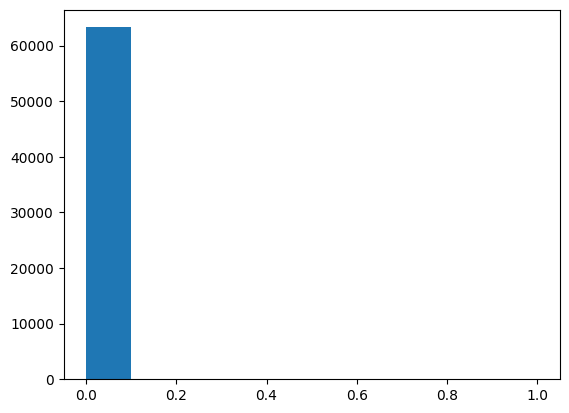

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(data.Duration)

### Применение линейной регрессии (10 баллов)

Это задача классификации, но её можно решить с помощью линейной регрессии, если округлять предсказанный ответ до целого и выбирать ближайший по значению ответ из множества {0, 1}.

Вынесите признак 'Claim' в вектор ответов и разделите датасет на обучающую и тестовую выборку в соотношении 80 к 20. Зафиксируйте random_state.

**Подсказка:** быстро перевести Yes/No в 1/0 можно так - np.where(df['Claim'] == 'Yes', 1,0)

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
# разделение на test/train
data['Claim'].replace('Yes', 1, inplace=True)
data['Claim'].replace('No', 0, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(data.drop(['Claim'], axis=1), data['Claim'], random_state=42, test_size=0.2)

/tmp/ipykernel_5145/3597574533.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Claim'].replace('Yes', 1, inplace=True)
/tmp/ipykernel_5145/3597574533.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

Найдите аналитическое решение для обучающей выборки: обычное и регуляризацией l2. 

In [52]:
from sklearn.metrics import mean_squared_error

In [53]:
# посчитайте аналитическое решение
X_t = X_train.transpose()
X_1 = np.linalg.inv(X_t @ X_train)
X_2 = X_1 @ X_t
w = X_2 @ y_train

In [54]:
mse_1 = mean_squared_error(y_test, np.array(X_test) @ w)

In [55]:
# посчитать аналитическое решение с регуляризацией
X_t = X_train.transpose()
X_1 = np.linalg.inv(X_t @ X_train + np.identity(X_t.shape[0])) # считаем, что лямбда равна 1
X_2 = X_1 @ X_t
w = X_2 @ y_train

In [56]:
mse_2 = mean_squared_error(y_test, np.array(X_test) @ w)

In [57]:
print(mse_1, mse_2)

0.01385174848546961 0.013851324710269826


Постройте модель LinearRegression, примените к тестовой выборке и посчитайте MSE (можно использовать библиотеку sklearn)

In [58]:
# обучите модель линейной регрессии LinearRegression на обучающей выборке, примените к тестовой

In [59]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X=X_train, y=y_train)

In [60]:
# посчитайте MSE, предварительно округлив предсказанные ответы до целого

In [61]:
from sklearn.metrics import mean_squared_error

mse_3 = mean_squared_error(y_test, (np.round(model.predict(X_test))).astype(int))

In [62]:
mse_3

0.014211274277593557

### Вывод (1 балла)

Напишите краткий вывод по заданию (достаточно пары предложений). Расскажите, какие способы предобработки данных вы выбрали и почему. Насколько хороша ваша модель?

После ряда экспериментов я решил полностью убрать категориальные признаки, при этом качество модели все-равно хорошее, при этом удалось найти и аналитическое решение

In [63]:
print(f'analytical solution: {mse_1}')
print(f'analytical solution with regularisation: {mse_2}')
print(f'sklearn linear regression: {mse_3}')

analytical solution: 0.01385174848546961
analytical solution with regularisation: 0.013851324710269826
sklearn linear regression: 0.014211274277593557


Наилучший результат показало аналитическое решение с регуляризацией, хотя решение без нее не сильно отсает, а вот решение с помощью sklearn показало результат заметно хуже